# **Spotify Premium Adoption Modeling Using Logistic Regression & Behavioral EDA**

This project investigates user-behavior drivers behind Spotify Premium adoption, with a focus on behavioral variables such as age segments, listening device types, and podcast satisfaction metrics. The analysis combines exploratory data analysis (EDA) and logistic regression to identify statistically meaningful predictors of subscription willingness.

---


# **1. Data Preparation**

In [14]:
import os
import os.path
import time
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import tensorflow as tf

import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import norm, t

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
os.getcwd()

'/content'

In [16]:
file_path = '/content/drive/MyDrive/Spotify_data_cleaned.csv'

In [33]:
df = pd.read_csv(file_path)
display(df.head())
df.info()
display(df.dtypes)
display(df.isnull().sum())

,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,...,fav_pod_genre,preffered_pod_format,pod_host_preference,preffered_pod_duration,pod_variety_satisfaction,Smart speakers or voice assistants,Wearable devices,Tablet,Smartphone,Computer or laptop
0,35-60,Others,3.0,['Smartphone'],Family Plan,Yes,Family Plan,Podcast,Pop,Afternoon,...,Comedy,NaN,NaN,<15 min,4,0,0,0,1,0
1,20-35,Male,1.0,['Smart speakers or voice assistants'],Family Plan,No,Family Plan,Podcast,Rock,Morning,...,Technology,Discussion,Both,<15 min,1,1,0,0,0,0
2,12-20,Female,3.0,['Computer or laptop'],Free,No,Student Plan,Music,Pop,Morning,...,NaN,NaN,Both,>30 min,5,0,0,0,0,1
3,12-20,Female,0.5,['Computer or laptop'],Student Plan,No,Individual Plan,Music,Rock,Night,...,NaN,NaN,Well known individuals,15-30 min,4,0,0,0,0,1
4,12-20,Male,2.0,['Smartphone'],Individual Plan,Yes,NaN,Podcast,Pop,Evening,...,NaN,Interview,Well known individuals,Unknown,5,0,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28546 entries, 0 to 28545
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 28546 non-null  object 
 1   Gender                              28546 non-null  object 
 2   spotify_usage_period                28546 non-null  float64
 3   spotify_listening_device            28546 non-null  object 
 4   spotify_subscription_plan           28546 non-null  object 
 5   premium_sub_willingness             28546 non-null  object 
 6   preffered_premium_plan              20473 non-null  object 
 7   preferred_listening_content         28546 non-null  object 
 8   fav_music_genre                     28546 non-null  object 
 9   music_time_slot                     28546 non-null  object 
 10  music_Influencial_mood              28546 non-null  object 
 11  music_lis_frequency                 28546

,0
Age,object
Gender,object
spotify_usage_period,float64
spotify_listening_device,object
spotify_subscription_plan,object
premium_sub_willingness,object
preffered_premium_plan,object
preferred_listening_content,object
fav_music_genre,object
music_time_slot,object


,0
Age,0
Gender,0
spotify_usage_period,0
spotify_listening_device,0
spotify_subscription_plan,0
premium_sub_willingness,0
preffered_premium_plan,8073
preferred_listening_content,0
fav_music_genre,0
music_time_slot,0


# **2. Exploratory data analysis (EDA)**



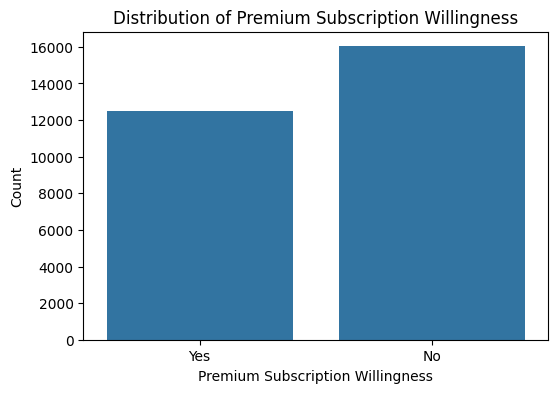

In [34]:
plt.figure(figsize=(6, 4))
sns.countplot(x='premium_sub_willingness', data=df)
plt.title('Distribution of Premium Subscription Willingness')
plt.xlabel('Premium Subscription Willingness')
plt.ylabel('Count')
plt.show()

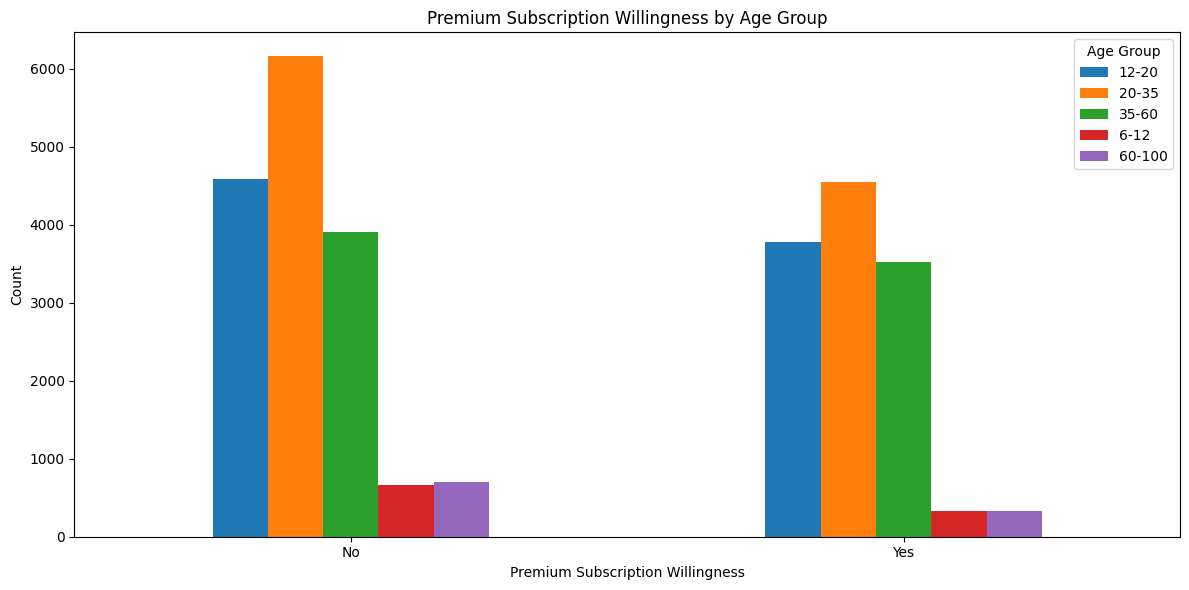

In [35]:
age_willingness = df.groupby(['Age', 'premium_sub_willingness']).size().unstack('Age')
age_willingness.plot(kind='bar', figsize=(12, 6))
plt.title('Premium Subscription Willingness by Age Group')
plt.xlabel('Premium Subscription Willingness')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

In [36]:
device_subscription_df = df[['premium_sub_willingness', 'Smartphone', 'Smart speakers or voice assistants', 'Computer or laptop', 'Wearable devices', 'Tablet']].copy()
device_subscription_df['premium_sub_willingness_dummy'] = device_subscription_df['premium_sub_willingness'].map({'Yes': 1, 'No': 0})

device_columns = ['Smartphone', 'Smart speakers or voice assistants', 'Computer or laptop', 'Wearable devices', 'Tablet']
correlation_results = {}
for device in device_columns:
    correlation, p_value = stats.pearsonr(device_subscription_df[device], device_subscription_df['premium_sub_willingness_dummy'])
    correlation_results[device] = {'correlation': correlation, 'p_value': p_value}

for device, result in correlation_results.items():
    print(f'{device} - Correlation: {result["correlation"]:.4f}, p-value: {result["p_value"]:.4f}')

Smartphone - Correlation: -0.0501, p-value: 0.0000
Smart speakers or voice assistants - Correlation: -0.0377, p-value: 0.0000
Computer or laptop - Correlation: -0.0445, p-value: 0.0000
Wearable devices - Correlation: -0.0882, p-value: 0.0000
Tablet - Correlation: 0.0541, p-value: 0.0000


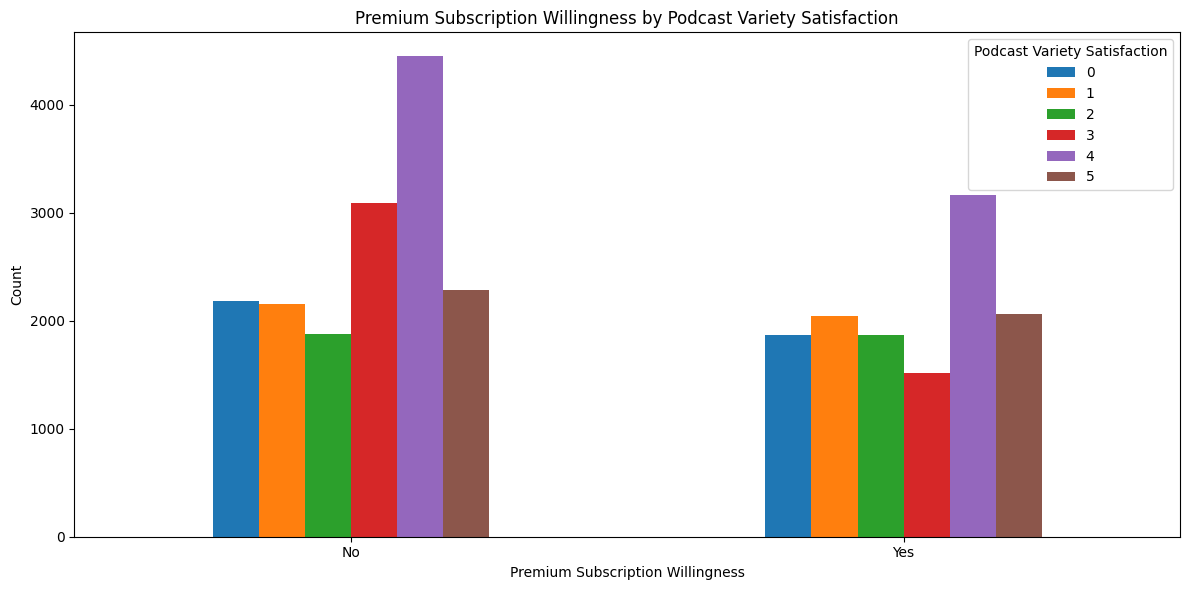

In [37]:
satisfaction_willingness = df.groupby(['pod_variety_satisfaction', 'premium_sub_willingness']).size().unstack('pod_variety_satisfaction')
satisfaction_willingness.plot(kind='bar', figsize=(12, 6))
plt.title('Premium Subscription Willingness by Podcast Variety Satisfaction')
plt.xlabel('Premium Subscription Willingness')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Podcast Variety Satisfaction')
plt.tight_layout()
plt.show()

# **3. Feature engineering**

In [38]:
# Create dummy variables for 'Age', dropping the first category
age_dummies = pd.get_dummies(df['Age'], prefix='Age', drop_first=True)

# Create dummy variables for 'Gender', dropping the first category
gender_dummies = pd.get_dummies(df['Gender'], prefix='Gender', drop_first=True)

# Create dummy variables for 'spotify_subscription_plan', dropping the first category
subscription_dummies = pd.get_dummies(df['spotify_subscription_plan'], prefix='Subscription', drop_first=True)

# Create interaction terms between 'Age' dummy variables and 'pod_variety_satisfaction'
age_satisfaction_interactions = age_dummies.multiply(df['pod_variety_satisfaction'], axis=0)
age_satisfaction_interactions.columns = [f'{col}_satisfaction' for col in age_satisfaction_interactions.columns]

# Create interaction terms between 'Gender' dummy variables and 'pod_variety_satisfaction'
gender_satisfaction_interactions = gender_dummies.multiply(df['pod_variety_satisfaction'], axis=0)
gender_satisfaction_interactions.columns = [f'{col}_satisfaction' for col in gender_satisfaction_interactions.columns]

# Create interaction terms between 'spotify_subscription_plan' dummy variables and 'pod_variety_satisfaction'
subscription_satisfaction_interactions = subscription_dummies.multiply(df['pod_variety_satisfaction'], axis=0)
subscription_satisfaction_interactions.columns = [f'{col}_satisfaction' for col in subscription_satisfaction_interactions.columns]

# Concatenate the new dummy variables and interaction terms with the original DataFrame
df = pd.concat([df, age_dummies, gender_dummies, subscription_dummies, age_satisfaction_interactions, gender_satisfaction_interactions, subscription_satisfaction_interactions], axis=1)

# Display the first few rows of the updated DataFrame
display(df.head())

,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,...,Age_20-35_satisfaction,Age_35-60_satisfaction,Age_6-12_satisfaction,Age_60-100_satisfaction,Gender_Male_satisfaction,Gender_Others_satisfaction,Subscription_Free_satisfaction,Subscription_Individual Plan_satisfaction,Subscription_Premium_satisfaction,Subscription_Student Plan_satisfaction
0,35-60,Others,3.0,['Smartphone'],Family Plan,Yes,Family Plan,Podcast,Pop,Afternoon,...,0,4,0,0,0,4,0,0,0,0
1,20-35,Male,1.0,['Smart speakers or voice assistants'],Family Plan,No,Family Plan,Podcast,Rock,Morning,...,1,0,0,0,1,0,0,0,0,0
2,12-20,Female,3.0,['Computer or laptop'],Free,No,Student Plan,Music,Pop,Morning,...,0,0,0,0,0,0,5,0,0,0
3,12-20,Female,0.5,['Computer or laptop'],Student Plan,No,Individual Plan,Music,Rock,Night,...,0,0,0,0,0,0,0,0,0,4
4,12-20,Male,2.0,['Smartphone'],Individual Plan,Yes,NaN,Podcast,Pop,Evening,...,0,0,0,0,5,0,0,5,0,0


# **4. Data preprocessing**


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Create a dummy variable for premium_sub_willingness if it doesn't exist
if 'premium_sub_willingness_dummy' not in df.columns:
    df['premium_sub_willingness_dummy'] = df['premium_sub_willingness'].map({'Yes': 1, 'No': 0})


# 1. Select features and target variable
feature_columns = ['spotify_usage_period', 'pod_variety_satisfaction', 'Smartphone',
                   'Smart speakers or voice assistants', 'Computer or laptop',
                   'Wearable devices', 'Tablet', 'Age_20-35', 'Age_35-60', 'Age_6-12',
                   'Age_60-100', 'Gender_Others', 'Subscription_Free',
                   'Subscription_Individual Plan', 'Subscription_Premium',
                   'Subscription_Student Plan', 'Age_20-35_satisfaction',
                   'Age_35-60_satisfaction', 'Age_6-12_satisfaction',
                   'Age_60-100_satisfaction', 'Gender_Others_satisfaction',
                   'Subscription_Free_satisfaction', 'Subscription_Individual Plan_satisfaction',
                   'Subscription_Premium_satisfaction', 'Subscription_Student Plan_satisfaction']

X = df[feature_columns]
y = df['premium_sub_willingness_dummy']

# 2. Handle missing values (using mean imputation for simplicity, consider other methods if needed)
# Check for missing values in the selected features
print("Missing values before imputation:")
print(X.isnull().sum())

# Impute missing values with the mean of each column
X = X.fillna(X.mean())

print("\nMissing values after imputation:")
print(X.isnull().sum())


# 3. Split the dataset into training and testing sets (80/20 split, stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]} rows")
print(f"Testing set size: {X_test.shape[0]} rows")

# 4. Scale numerical features
# Identify numerical columns that need scaling (excluding dummy and interaction terms with dummies)
numerical_cols = ['spotify_usage_period', 'pod_variety_satisfaction'] # Add other numerical columns if any

scaler = StandardScaler()

# Apply scaling to the training data
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

# Apply scaling to the testing data using the scaler fitted on the training data
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("\nScaled training data (first 5 rows):")
display(X_train.head())
print("\nScaled testing data (first 5 rows):")
display(X_test.head())

Missing values before imputation:
spotify_usage_period                         0
pod_variety_satisfaction                     0
Smartphone                                   0
Smart speakers or voice assistants           0
Computer or laptop                           0
Wearable devices                             0
Tablet                                       0
Age_20-35                                    0
Age_35-60                                    0
Age_6-12                                     0
Age_60-100                                   0
Gender_Others                                0
Subscription_Free                            0
Subscription_Individual Plan                 0
Subscription_Premium                         0
Subscription_Student Plan                    0
Age_20-35_satisfaction                       0
Age_35-60_satisfaction                       0
Age_6-12_satisfaction                        0
Age_60-100_satisfaction                      0
Gender_Others_satisfaction

,spotify_usage_period,pod_variety_satisfaction,Smartphone,Smart speakers or voice assistants,Computer or laptop,Wearable devices,Tablet,Age_20-35,Age_35-60,Age_6-12,...,Subscription_Student Plan,Age_20-35_satisfaction,Age_35-60_satisfaction,Age_6-12_satisfaction,Age_60-100_satisfaction,Gender_Others_satisfaction,Subscription_Free_satisfaction,Subscription_Individual Plan_satisfaction,Subscription_Premium_satisfaction,Subscription_Student Plan_satisfaction
24052,0.396163,-1.024679,0,0,1,0,0,False,False,True,...,False,0,0,1,0,0,1,0,0,0
21056,-1.165870,0.170579,0,0,0,1,0,True,False,False,...,False,3,0,0,0,0,3,0,0,0
7091,-0.645192,-0.427050,0,0,0,0,1,False,True,False,...,False,0,2,0,0,0,0,2,0,0
12973,-1.165870,-0.427050,0,0,0,0,1,True,False,False,...,False,2,0,0,0,0,0,2,0,0
1385,-0.645192,-0.427050,1,0,0,0,0,False,True,False,...,False,0,2,0,0,0,0,2,0,0



Scaled testing data (first 5 rows):


,spotify_usage_period,pod_variety_satisfaction,Smartphone,Smart speakers or voice assistants,Computer or laptop,Wearable devices,Tablet,Age_20-35,Age_35-60,Age_6-12,...,Subscription_Student Plan,Age_20-35_satisfaction,Age_35-60_satisfaction,Age_6-12_satisfaction,Age_60-100_satisfaction,Gender_Others_satisfaction,Subscription_Free_satisfaction,Subscription_Individual Plan_satisfaction,Subscription_Premium_satisfaction,Subscription_Student Plan_satisfaction
17421,-0.645192,-0.427050,1,0,0,0,0,False,True,False,...,False,0,2,0,0,0,0,2,0,0
16895,1.437517,0.768209,0,0,0,0,1,False,True,False,...,False,0,4,0,0,0,0,0,0,0
14983,-1.165870,-1.622309,0,1,0,0,0,False,False,False,...,False,0,0,0,0,0,0,0,0,0
26652,-1.165870,1.365838,0,1,0,0,0,True,False,False,...,False,5,0,0,0,0,5,0,0,0
13887,1.437517,0.768209,0,0,1,0,0,False,True,False,...,False,0,4,0,0,4,0,4,0,0


# **5. Model building**



In [40]:
from sklearn.linear_model import LogisticRegression

# Instantiate a Logistic Regression model
model = LogisticRegression(random_state=42)

# Fit the logistic regression model to the training data
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

# **6. Model evaluation**



In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1. Use the fitted logistic regression model to make predictions on the test set (X_test).
y_pred = model.predict(X_test)

# 2. Calculate the accuracy, precision, recall, and F1-score using y_test and the predicted values.
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 3. Calculate the predicted probabilities for the positive class (premium subscription) on the test set.
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 4. Calculate the AUC-ROC score using y_test and the predicted probabilities.
auc_roc = roc_auc_score(y_test, y_pred_proba)

# 5. Print the calculated evaluation metrics.
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.5615
Precision: 0.5000
Recall: 0.1905
F1-score: 0.2759
AUC-ROC: 0.5797


# **7. Model interpretation**

In [42]:
# 1. Access the coefficients of the fitted logistic regression model.
coefficients = model.coef_[0]

# 2. Access the names of the features used in the model.
feature_names = X_train.columns

# 3. Create a Pandas DataFrame to store the feature names and their corresponding coefficients.
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# 4. Sort the DataFrame by the absolute value of the coefficients to easily identify the most influential features.
coefficients_df['Abs_Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

# 5. Print or display the sorted DataFrame to examine the magnitude and direction of the coefficients for each feature.
display(coefficients_df)

# 6. Interpret the coefficients (This is done by examining the displayed DataFrame)

,Feature,Coefficient,Abs_Coefficient
14,Subscription_Premium,-0.303997,0.303997
10,Age_60-100,-0.179584,0.179584
12,Subscription_Free,-0.160816,0.160816
5,Wearable devices,-0.140457,0.140457
2,Smartphone,-0.138327,0.138327
3,Smart speakers or voice assistants,-0.110402,0.110402
4,Computer or laptop,-0.110394,0.110394
9,Age_6-12,-0.074438,0.074438
8,Age_35-60,0.054002,0.054002
7,Age_20-35,-0.050619,0.050619


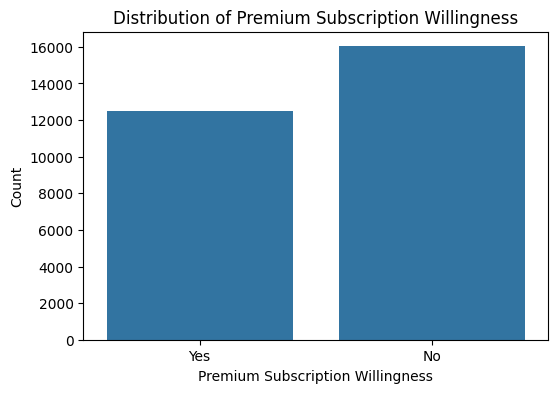

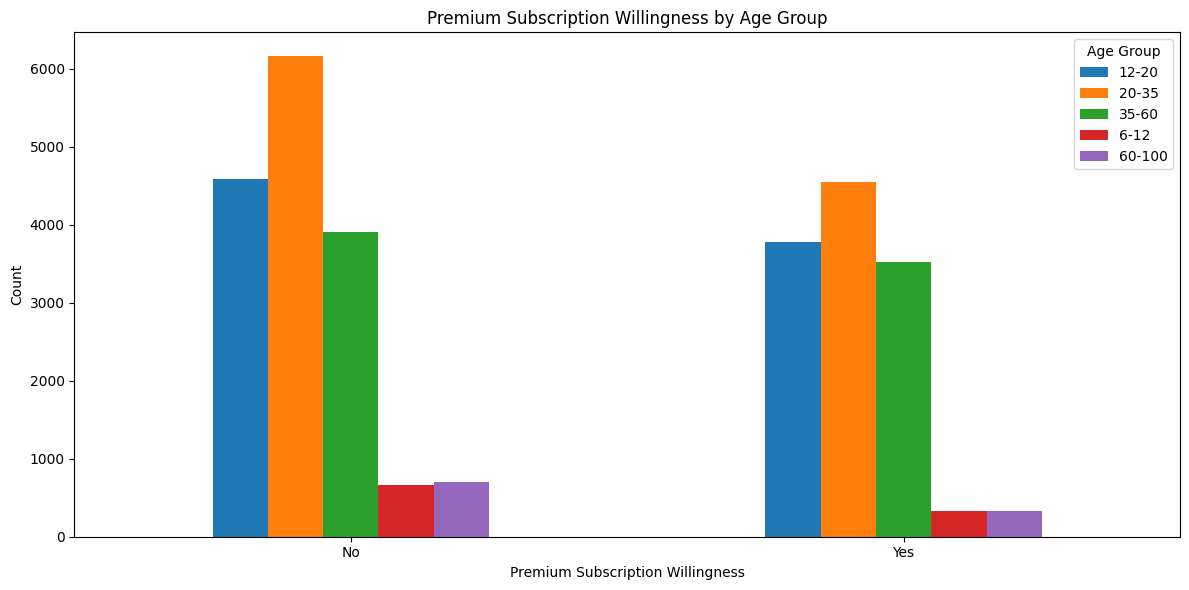

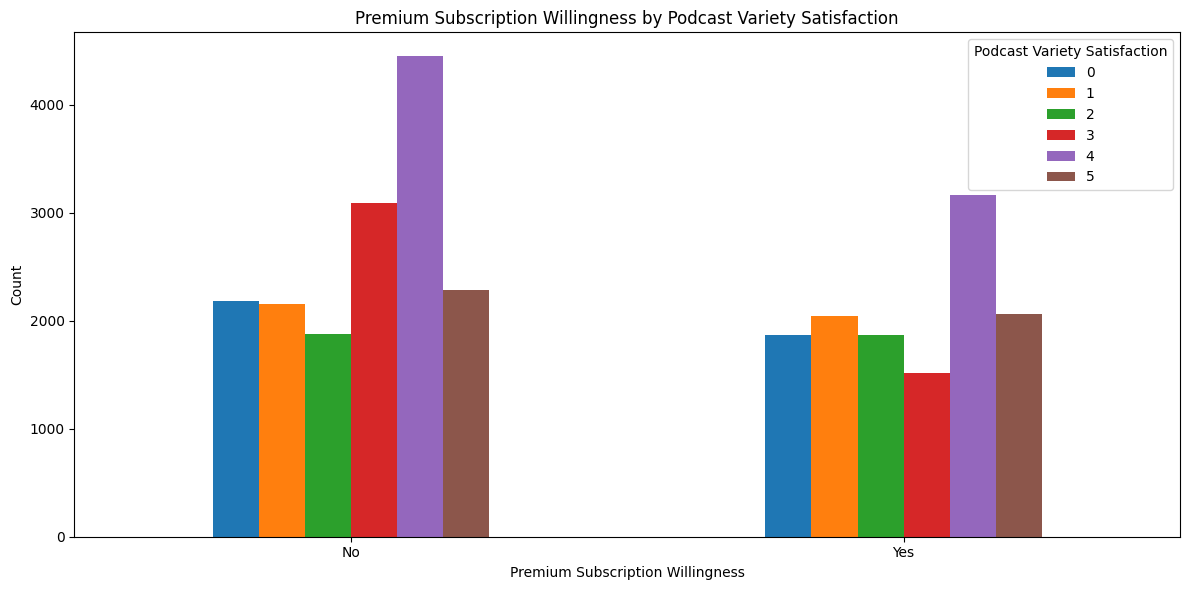

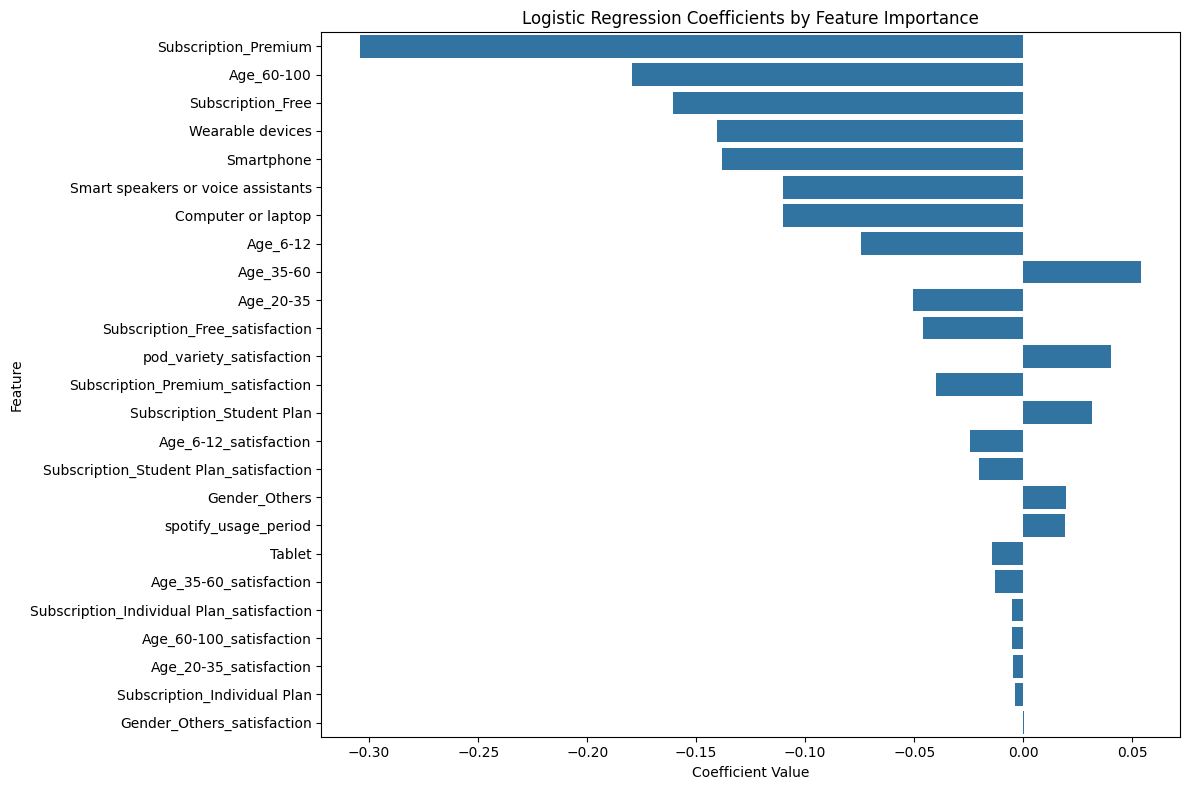

In [43]:
# 1. Distribution of Premium Subscription Willingness (from previous EDA)
plt.figure(figsize=(6, 4))
sns.countplot(x='premium_sub_willingness', data=df)
plt.title('Distribution of Premium Subscription Willingness')
plt.xlabel('Premium Subscription Willingness')
plt.ylabel('Count')
plt.show()

# 2. Premium Subscription Willingness by Age Group (from previous EDA)
age_willingness = df.groupby(['Age', 'premium_sub_willingness']).size().unstack('Age')
age_willingness.plot(kind='bar', figsize=(12, 6))
plt.title('Premium Subscription Willingness by Age Group')
plt.xlabel('Premium Subscription Willingness')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

# 3. Premium Subscription Willingness by Podcast Variety Satisfaction (from previous EDA)
satisfaction_willingness = df.groupby(['pod_variety_satisfaction', 'premium_sub_willingness']).size().unstack('pod_variety_satisfaction')
satisfaction_willingness.plot(kind='bar', figsize=(12, 6))
plt.title('Premium Subscription Willingness by Podcast Variety Satisfaction')
plt.xlabel('Premium Subscription Willingness')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Podcast Variety Satisfaction')
plt.tight_layout()
plt.show()

# 4. Bar plot of Logistic Regression Coefficients (from model interpretation)
# Assuming 'coefficients_df' is available from the previous model interpretation step
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_df)
plt.title('Logistic Regression Coefficients by Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# **8. Summary of Behavioral Drivers for Spotify Premium Adoption**

Based on the Exploratory Data Analysis and Logistic Regression Model:

## Key Insights from EDA:
- **Premium Subscription Willingness Distribution:** The dataset shows a relatively balanced distribution between users willing and unwilling to subscribe to premium.
- **Age and Premium Subscription Willingness:** While all age groups have both willing and unwilling subscribers, the distribution varies. (Refer to the 'Premium Subscription Willingness by Age Group' plot)
- **Listening Devices and Premium Subscription:** Correlation analysis indicated statistically significant but weak correlations between specific device usage and premium subscription willingness. (Refer to correlation results printed previously)
- **Podcast Variety Satisfaction and Premium Subscription:** There appears to be a relationship between podcast variety satisfaction levels and premium subscription willingness, as visualized in the grouped bar chart. Higher satisfaction levels seem to correspond to a higher proportion of users willing to subscribe. (Refer to the 'Premium Subscription Willingness by Podcast Variety Satisfaction' plot)

## Key Insights from Logistic Regression Model Interpretation:
The logistic regression model provides insights into the independent impact of each feature on the likelihood of premium subscription willingness. (Refer to the 'Logistic Regression Coefficients by Feature Importance' bar plot and the coefficients_df DataFrame)

Notably:
- Features related to the *current subscription plan* (e.g., Subscription_Premium, Subscription_Free) have strong associations, which is expected as the current plan is a direct indicator of willingness.
- Age groups also show significant associations with willingness.
- Device usage features (e.g., Wearable devices, Smartphone) have notable coefficients, suggesting a relationship with willingness, although the direction and strength vary by device.
- Podcast variety satisfaction also has a positive coefficient, indicating that higher satisfaction is associated with a higher likelihood of premium subscription.

In [45]:
display(coefficients_df.head(10))

,Feature,Coefficient,Abs_Coefficient
14,Subscription_Premium,-0.303997,0.303997
10,Age_60-100,-0.179584,0.179584
12,Subscription_Free,-0.160816,0.160816
5,Wearable devices,-0.140457,0.140457
2,Smartphone,-0.138327,0.138327
3,Smart speakers or voice assistants,-0.110402,0.110402
4,Computer or laptop,-0.110394,0.110394
9,Age_6-12,-0.074438,0.074438
8,Age_35-60,0.054002,0.054002
7,Age_20-35,-0.050619,0.050619


# **9. Conclusions**
Based on this analysis, several behavioral factors appear to be drivers of Spotify Premium adoption:
- **Current Subscription Status:** The user's current subscription plan is a strong predictor of future premium willingness.
- **Age:** Age groups play a role in subscription willingness, with some age segments showing higher or lower propensity for premium.
- **Listening Devices:** The type of device used for listening is associated with premium subscription, potentially reflecting different usage patterns or user segments.
- **Podcast Variety Satisfaction:** Satisfaction with the variety of podcasts available on Spotify is a positive driver of premium subscription willingness.